In [45]:
from torchvision import datasets, transforms
import torch as th 
import numpy as np 

In [52]:
from pathlib import Path 

ROOT = Path(__name__).absolute().parents[1]


def get_fmnist(train: bool) -> tuple[th.Tensor, th.Tensor]:
    fmnist = datasets.FashionMNIST(str(ROOT / "datasets"), download=True, train=train)
    selected_classes = [fmnist.classes.index("Sandal"), fmnist.classes.index("Dress")]

    selected_indices = th.isin(fmnist.targets, th.Tensor(selected_classes))
    targets_relabeled = fmnist.targets[selected_indices]
    for i, original in enumerate(selected_classes):
        targets_relabeled[targets_relabeled == original] = i 

    return fmnist.data[selected_indices], targets_relabeled


X_train, y_train = get_fmnist(train=True)
X_test, y_test = get_fmnist(train=False)


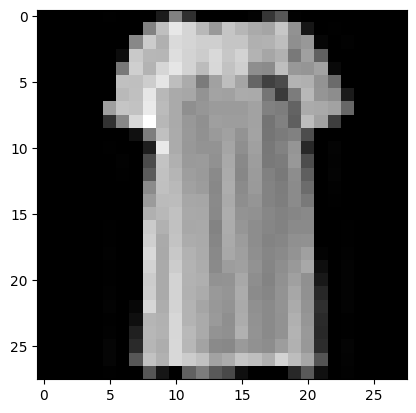

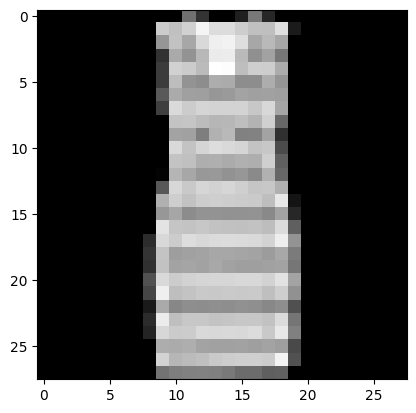

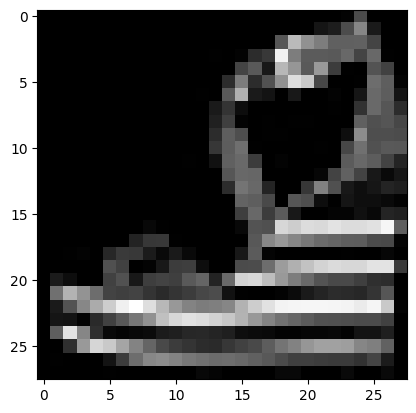

In [44]:
import matplotlib.pyplot as plt 
import random 


for idx in random.sample(range(X_test.shape[0]), 3):
    plt.imshow(X_train[idx], cmap="gray")
    plt.show()

## Model

In [144]:
from typing import Callable
from tqdm import tqdm 


class LogisticRegression(th.nn.Module):
    _device = th.device("cuda" if th.cuda.is_available() else "cpu")

    @staticmethod
    def preprocess(data: th.Tensor) -> th.Tensor:
        if data.dtype == th.uint8:
            data = data / 255.0
        data = data.flatten(start_dim=1)
        return data
        
    def __init__(self, n_features: int):
        super(LogisticRegression, self).__init__()
        self.weights = th.nn.Linear(n_features, 1, bias=True)
        self.activation = th.nn.Sigmoid()

    def forward(self, x: th.Tensor) -> th.Tensor:
        preprocessed = self.preprocess(x)
        out = self.weights.forward(preprocessed)
        return self.activation(out)

    def fit(self, X: th.Tensor, y: th.Tensor, epochs: int, optimizer: th.optim.Optimizer, eval_data: tuple[th.Tensor, th.Tensor] | None=None, eval_freq: int=10) -> tuple[list[float], list[float]]:
        loss_fn = th.nn.BCELoss()
        val_losses = []
        train_losses = []

        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()

            outs = th.squeeze(self(X))
            loss = loss_fn(outs, y)

            loss.backward()
            optimizer.step()
            if epoch % eval_freq == 0 and eval_data:
                val_loss = self.eval(eval_data[0], eval_data[1], loss_fn)
                train_losses.append(loss.item())
                val_losses.append(val_loss.item())
        return train_losses, val_losses
            

    def eval(self, X: th.Tensor, y: th.Tensor, loss_fn: Callable[[th.Tensor, th.Tensor], th.Tensor]) -> th.Tensor:
        with th.no_grad():
            outs = th.squeeze(self(X))
            loss = loss_fn(outs, y)
        return loss 

In [156]:
model = LogisticRegression(X_test.size(1) * X_test.size(2))
model.forward(X_train[5][None, :, :]).dtype

torch.float32

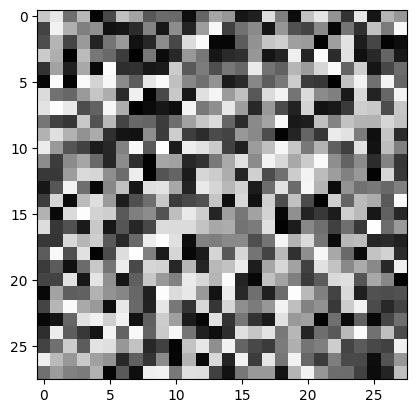

In [157]:
weights, bias = model.parameters()
plt.imshow(weights.detach().reshape((28, 28)), cmap="gray")

In [158]:
optimizer = th.optim.SGD(model.parameters(), lr=0.05)
train_loss, test_loss = model.fit(X_train, y_train.type(th.float32), 300, optimizer, eval_data=(X_test, y_test.type(th.float32)))

100%|██████████| 300/300 [00:06<00:00, 42.98it/s]


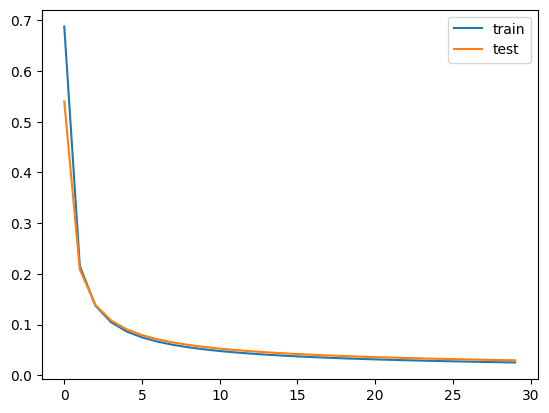

In [159]:
ax = list(range(len(train_loss)))
plt.plot(ax, train_loss, label="train")
if test_loss:
    plt.plot(ax, test_loss, label="test")
plt.legend()
plt.show()

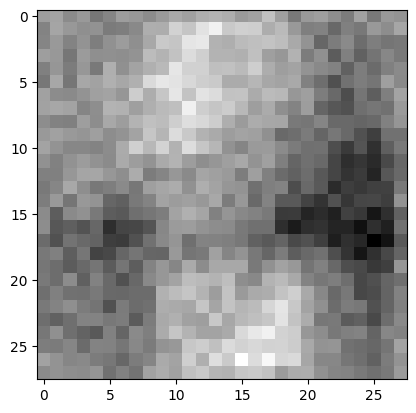

In [160]:
weights, bias = model.parameters()
plt.imshow(weights.detach().reshape((28, 28)), cmap="gray")

In [161]:
test_pred = th.squeeze(model.forward(X_test))
acc = (test_pred.round() == y_test).sum() / test_pred.size(0)
print(f"acc: {acc}")

acc: 0.9934999942779541


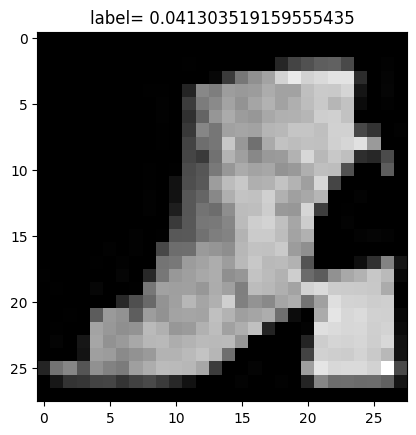

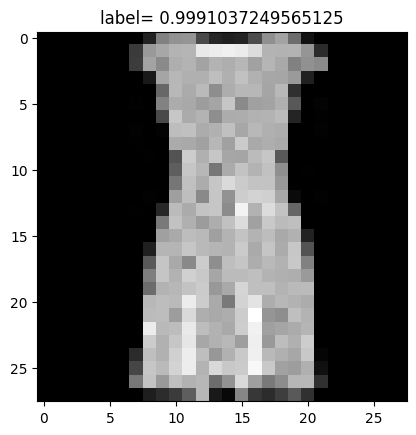

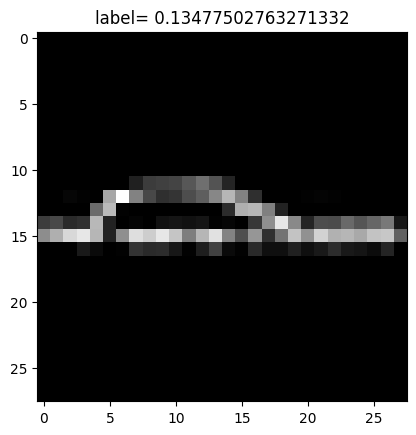

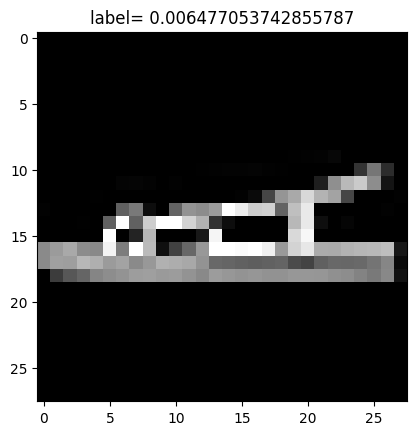

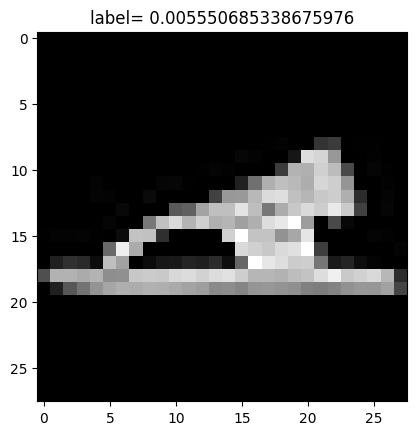

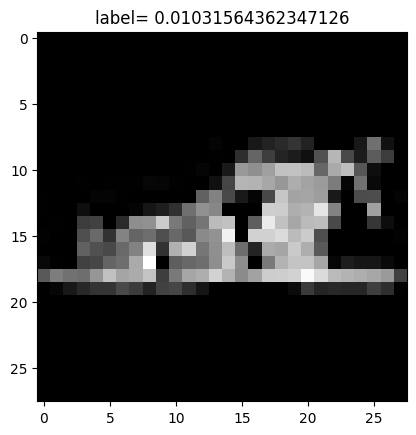

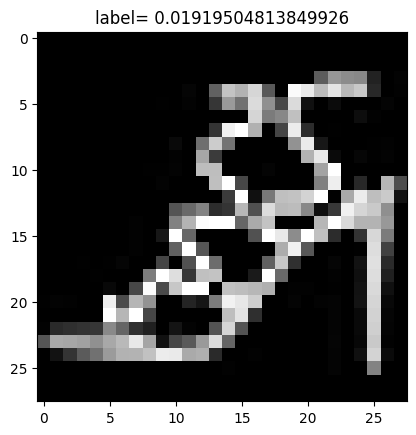

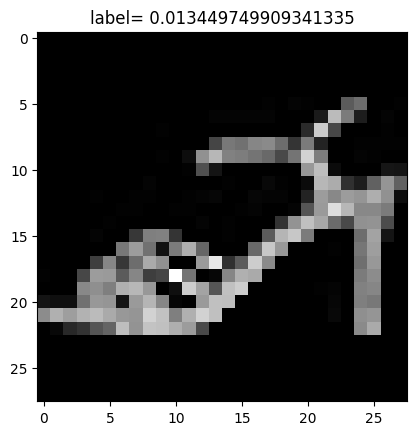

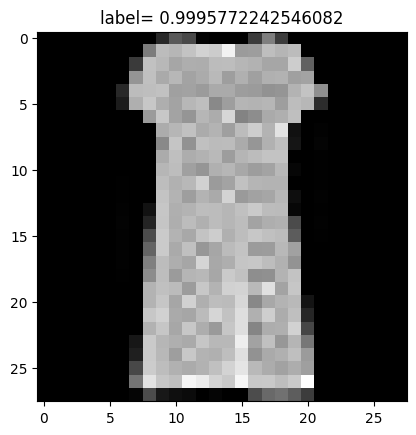

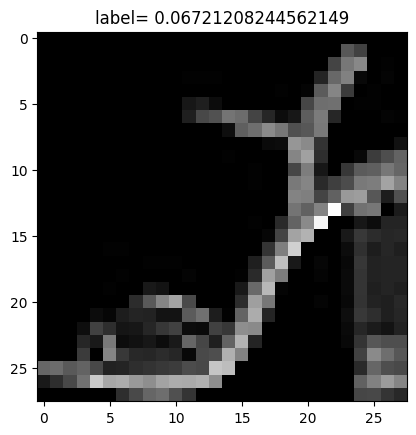

In [168]:
for idx in random.sample(range(X_test.size(0)), 10):
    label = th.squeeze(model.forward(X_test[idx][None, :, :]))
    plt.title(f"label= {label}")
    plt.imshow(X_test[idx], cmap="gray")
    plt.show()